In [2]:
%%capture
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip3 install seaborn
import string

In [3]:
import seaborn as sns

# Load, Inspect, and Clean Both DF's

In [4]:
data = pd.read_pickle('../Data/stories') # read in data from pickle
story_df = pd.DataFrame(data) # create df of stories from pickled data
raw_df = pd.DataFrame(pd.read_csv("../nytwit_v1-1.tsv", sep='\t')) # core df we will concat story data to


In [5]:
raw_df_filtered = raw_df.drop(raw_df.loc[raw_df['URL'].values == 'not found'].index, axis = 0) # drop rows where URL is not found


In [6]:
story_df = story_df.rename(columns={
    0:"Story_Examples"
})
story_df.head()

,Story_Examples
0,“How much does it cost ” I asked Hirota We wer...
1,“How much does it cost ” I asked Hirota We wer...
2,“How much does it cost ” I asked Hirota We wer...
3,Last month an Access Hollywood correspondent ...
4,CANYON DE CHELLY Ariz — A sliver moon dangle...


### Clean up the Story DF

In [7]:
story_df.reset_index(drop=True, inplace=True)

def remove_punctuation(text):
    no_punct = "".join([w for w in text if w not in string.punctuation])
    return no_punct

story_df['Story_Examples'] = story_df['Story_Examples'].apply(lambda x: remove_punctuation(x)) # remove punctuation from sentences

In [8]:
story_df.head(10) 

,Story_Examples
0,“How much does it cost ” I asked Hirota We wer...
1,“How much does it cost ” I asked Hirota We wer...
2,“How much does it cost ” I asked Hirota We wer...
3,Last month an Access Hollywood correspondent ...
4,CANYON DE CHELLY Ariz — A sliver moon dangle...
5,THE PURLOINING OF PRINCE OLEOMARGARINE By Mark...
6,THE PURLOINING OF PRINCE OLEOMARGARINE By Mark...
7,Tom UttechThrough Nov 25 Alexandre Gallery 7...
8,It is surely one of New York’s grandest sights...
9,It is surely one of New York’s grandest sights...


### Clean up the NYTwit DF

In [9]:
raw_df_filtered.reset_index(drop=True, inplace=True)
raw_df_filtered.head()

,Time,Word,Category,URL
0,Tue Nov 07 19:12:11 2017,ujigami,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
1,Tue Nov 07 19:12:15 2017,ganbarro,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
2,Tue Nov 07 19:12:25 2017,yamahoko,filtered,https://www.nytimes.com/2017/11/07/travel/shri...
3,Wed Nov 08 10:01:04 2017,rememed,affix,https://www.nytimes.com/2017/11/08/opinion/ang...
4,Wed Nov 08 11:01:14 2017,andpinyon,filtered,https://www.nytimes.com/2017/11/08/sports/nava...


### Concat dataframes, perform final inspections of the data

In [139]:
df = pd.concat([raw_df_filtered, story_df], axis =1)

In [140]:
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['Time', 'Word', 'Category', 'URL', 'Story_Examples'], dtype='object')

In [141]:
df = df.drop(df.loc[df['Story_Examples'] == ''].index, axis = 0) # drop rows with no stories , i.e. the URL did not work or the stories are no longer public
df.reset_index(drop=True, inplace=True)


In [142]:
df.Story_Examples # area for improvement: some scraped stories included parts of titles

0       “How much does it cost ” I asked Hirota We wer...
1       “How much does it cost ” I asked Hirota We wer...
2       “How much does it cost ” I asked Hirota We wer...
3       Last month  an Access Hollywood correspondent ...
4       CANYON DE CHELLY  Ariz  — A sliver moon dangle...
                              ...                        
2577    LOS ANGELES — Even before she turned 17 in Dec...
2578    LOS ANGELES — Even before she turned 17 in Dec...
2579    ImageCredit   Till Lauer A newsletter for pare...
2580    Great horror writing is more than cheap scares...
2581    There they are  the racks of meat on skewers a...
Name: Story_Examples, Length: 2582, dtype: object

### Number of NA's

In [204]:
sum(pd.isna(df.Story_Examples))

0

# Calculate Summary Stats of stories in Story_Examples

In [205]:
cleaned_stories = [nltk.word_tokenize(str(story).replace('—', '').replace('’', '').replace('”', '').replace('“', '').replace(",", '').replace("(", '').replace(")", "")) for story in df.Story_Examples]
# list of each story tokenized & cleaned

In [206]:
story_lengths_all = [len(story) for story in cleaned_stories] # lengths for every story
max_min_difference = abs(np.min(story_lengths_all) - np.max(story_lengths_all))

#5-number summary
min_ = np.min(story_lengths_all)
q1 = np.quantile(a = story_lengths_all, q = .25)
q2 = np.quantile(a = story_lengths_all, q = .5)
q3 = np.quantile(a = story_lengths_all, q = .75)
max_ = np.max(story_lengths_all)
#basic stats
iqr = q3 - q1

max_non_outlier = q3 + 1.5*iqr # max threshold
min_non_outlier = q1 - 1.5*iqr # min threshold

# subsets of data
outlier_story_lengths = [length for length in story_lengths_all if (length > max_non_outlier) | (length < min_non_outlier)]
remove_extremities = [val for val in story_lengths_all if val < 4000]


print("IQR is {}".format(iqr))
print("MAX is {}".format(max_))
print("MIN is {}".format(min_))
print("Q1 is {}".format(q1))
print("Q3 is {}".format(q3))
print("Min Outlier Threshold is {}".format(min_non_outlier))
print("Max Outlier Threshold is {}".format(max_non_outlier))
print(str(round((len(outlier_story_lengths)/len(story_lengths_all))*100, 2)) + "% of the story lengths are outliers.") # % of dataset that is an outlier...


IQR is 668.25
MAX is 12253
MIN is 82
Q1 is 860.25
Q3 is 1528.5
Min Outlier Threshold is -142.125
Max Outlier Threshold is 2530.875
8.71% of the story lengths are outliers.


[[]]

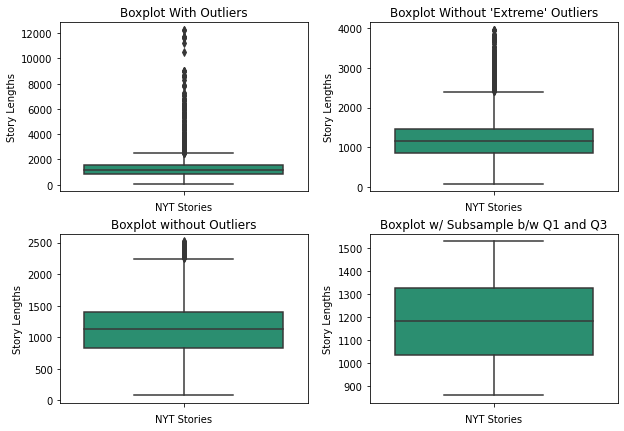

In [207]:
# set up figure
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2)
fig.set_figheight(7)
fig.set_figwidth(10)
plt.subplots_adjust(wspace = .25, hspace=.25)

#subplot 0,0
ax1.title.set_text("Boxplot With Outliers")
ax1.set_xlabel("NYT Stories")
ax1.set_ylabel("Story Lengths")
plot1 = sns.boxplot(data = story_lengths_all, color=sns.set_palette("Dark2"), ax=ax1)
plot1.set(xticklabels=[])


#subplot 0,1
ax2.title.set_text("Boxplot Without 'Extreme' Outliers")
ax2.set_xlabel("NYT Stories")
ax2.set_ylabel("Story Lengths")
plot2 =sns.boxplot(data = remove_extremities, ax=ax2) 
plot2.set(xticklabels=[])

#subplot 1, 0
ax3.title.set_text("Boxplot without Outliers")
ax3.set_xlabel("NYT Stories")
ax3.set_ylabel("Story Lengths")
plot3 = sns.boxplot(data = [length for length in story_lengths_all if ((length>= min_non_outlier) & (length <= max_non_outlier))], ax = ax3)
plot3.set(xticklabels=[])

#subplot 1, 1
ax4.title.set_text("Boxplot w/ Subsample b/w Q1 and Q3")
ax4.set_xlabel("NYT Stories")
ax4.set_ylabel("Story Lengths")
plot4 = sns.boxplot(data = [length for length in story_lengths_all if ((length>=q1) & (length <= q3))], ax = ax4)
plot4.set(xticklabels=[])

# Empirical CDF to show us what % of the data lies below a certain sentence length 

Text(0, 0.5, '% of stories')

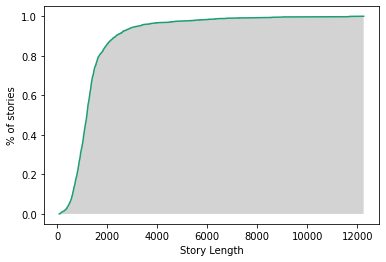

In [208]:
plt.plot(np.sort(story_lengths_all), np.linspace(0, 1, len(story_lengths_all)))
plt.fill_between(np.sort(story_lengths_all), np.linspace(0, 1, len(story_lengths_all)), facecolor='lightgray')
plt.xlabel("Story Length")
plt.ylabel("% of stories")

 roughly 90% of our story lengths fall below 2000 words. 

## To Do: 

### 1. Create an array of stories, story lengths, and words that are within the IQR
### 2. Calculate the TF and IDF for those words using the tf and idf functions.

In [210]:
iqr_stories = [] # store stories with lengths within the IQR
iqr_indices = [] # store indices of words with story lengths within the IQR
count = 0
for story in cleaned_stories:
    count += 1
    if (len(story) >= q1) & (len(story) <= q3):
        joined_story = " ".join(story)
        iqr_indices.append(count)
        iqr_stories.append(joined_story)

In [211]:
iqr_story_lengths = [len(story) for story in cleaned_stories if (len(story) >= q1) & (len(story) <= q3)] # lengths for stories between q1 and q3
len(q1_to_q3_story_lengths)

1290

In [212]:
iqr_words = [df['Word'].iloc[iqr_indices[i] -1] for i in range(len(iqr_indices))] # list of words within q1 to q3
len(iqr_words)

1290

In [213]:
iqr_words[:5]

['underdramatic', 'hyperhysteria', 'verbolect', 'fluffypoos', 'shaggydoodles']

In [214]:
iqr_story_lengths[:5]

[1243, 1243, 1239, 1152, 1152]

In [215]:
iqr_indices[:5]

[6, 7, 8, 9, 10]

In [216]:
len(iqr_stories) == len(iqr_indices) == len(iqr_story_lengths) == len(iqr_words)

True

# Term Frequency

$$tf(t, d) = \frac{count\space of\space t\space in\space d}{number\space of\space words\space in\space d}$$

### For this calculation, I will weight all parts of the document the same. This is because our 'document' is defined as the body of the article

Note: Cleaning the text was a challenge, and some titles have squared through the cleaning process. This is the main area
to improve on moving forward

### Example for First Word

In [217]:
df.head(1)

,Time,Word,Category,URL,Story_Examples
0,Tue Nov 07 19:12:11 2017,ujigami,filtered,https://www.nytimes.com/2017/11/07/travel/shri...,“How much does it cost ” I asked Hirota We wer...


$$tf(ujigami, "How\space much\space does\space it...") = \frac{count\space of\space ujigami\space in\space "How\space much\space does\space it..."}{number\space of\space words\space in\space "How\space much\space does\space it..."}$$



In [232]:
def FreqDist(t, d):
    """
    @params: t, list of terms and d, list of documents
    @returns the frequency of a word in a document
    """
    frequency_tracker = []
    for i in range(len(t)):
        count = 0
        for w in nltk.word_tokenize(d[i]): # for word in story (tokenized)
            if w == t[i]: # if word == term
                count += 1
        frequency_tracker.append(count)
    return frequency_tracker

In [234]:
FreqDist(iqr_words[:10], iqr_stories[:10])

[1, 1, 2, 1, 1, 1, 0, 1, 4, 1]

In [252]:
term_frequencies = np.divide((FreqDist(iqr_words, iqr_stories)), ([length for length in iqr_story_lengths]))

In [253]:
term_frequencies_rounded = [np.round(tf, 5) for tf in term_frequencies]

In [254]:
term_frequencies_rounded[:10]

[0.0008,
 0.0008,
 0.00161,
 0.00087,
 0.00087,
 0.00084,
 0.0,
 0.00087,
 0.00362,
 0.00089]

### With TF, the length of the document can be dominated by words such as 'and,' 'had,' and other fillers. This can skew the TF and provide us with invaluable information.

### TF-IDF will 'regularize' our documents 
(think of regularization in SVM where large ranges of #'s that aren't normalized can skew the decision boundary, so we scale the axes). This helps hold constant the effect of filler words.

# TF-IDF now

### 1. Create list of all words across all stories

This is more efficient to search through

In [263]:
join_each_story = [] # join each story together

string_to_search = " ".join(str(w) for w in iqr_stories) # list of all story words to search through


### 2. Perform Document Frequency Calculation


In [282]:
df_tracker = []
for i in range(len(iqr_stories)):
    count = 0
    word = iqr_words[i]
    for story in iqr_stories:
        if word in story: # count number of times the word occurs in a story
            count += 1
    df_tracker.append(count) # append that count to the tracker

### Perform IDF Calculation

$$IDF(t) = \frac{N}{df + 1}$$

N is the number of documents, add one to denominator to avoid division by 0

In [303]:
import math
def idf(d):
    idf_tracker = []
    for i in range(len(d)):
         idf_tracker.append(len(d)/(df_tracker[i] + 1))
    return idf_tracker

In [304]:
idf_list = list(idf(iqr_stories))

In [305]:
idf_list[:10]

[430.0, 430.0, 645.0, 430.0, 430.0, 645.0, 1290.0, 645.0, 645.0, 430.0]

# 4. Calculate log-idf (smoothing the freq):
use math.log10() to calculate the log of the idf <br>

$$\log{IDF(t)} = \log{\frac{N}{df+1}}$$

In [306]:
import math
log_idf_list = [np.round(math.log(idf),5) for idf in idf_list]
log_idf_list[:10]

[6.06379,
 6.06379,
 6.46925,
 6.06379,
 6.06379,
 6.46925,
 7.1624,
 6.46925,
 6.46925,
 6.06379]

# 5. Calculate tf-idf
$$ tf-idf = tf(t, d) * log(\frac{N}{df+1}) = \textrm{term_frequencies[i] * log_idf_list[i]} $$

In [307]:
tf_idf_list = [term_frequencies_rounded[i]*log_idf_list[i] for i in range(len(term_frequencies_rounded))]

len(tf_idf_list)

1290

In [308]:
tf_idf_dict = dict(zip(iqr_words, tf_idf_list))


In [309]:
tfidf_df = pd.DataFrame(tf_idf_dict.items(), columns = ["Word", "TF-IDF_Score"])

In [310]:
tfidf_df.loc[tfidf_df['TF-IDF_Score'] == 0]

,Word,TF-IDF_Score
6,initiativeson,0.0
14,individualmandate,0.0
17,agreementsm,0.0
26,domesticairlines,0.0
35,fluoroscent,0.0
...,...,...
1261,thruppling,0.0
1275,wrirting,0.0
1285,b’mitzvahs,0.0
1286,b’mitzvah,0.0


In [311]:
tfidf_df.loc[tfidf_df['TF-IDF_Score'] != 0]

,Word,TF-IDF_Score
0,underdramatic,0.004851
1,hyperhysteria,0.004851
2,verbolect,0.010415
3,fluffypoos,0.005275
4,shaggydoodles,0.005275
...,...,...
1281,starhuggers,0.004723
1282,amsah,0.006534
1283,coxswaining,0.005094
1284,workkkk,0.005094


In [313]:
tfidf_df.to_csv("tfidf-scores.csv")